<a href="https://colab.research.google.com/github/odartsi/Healthcare/blob/main/Parkinson_Predictions/LSTM_Time_Series_Forecasting_Parkinson_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

## Load data

In [2]:
train_clinical_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_clinical_data.csv')
train_peptides_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_peptides.csv')
train_proteins_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/train_proteins.csv')
sumplimental_clinical_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amp-parkisons-disease-progression-predictions/supplemental_clinical_data.csv')

In [163]:
sumplimental_clinical_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [164]:
train_clinical_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [167]:
train_peptides_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [168]:
train_proteins_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


**train_clinical_data.csv**

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `updrs_[1-4]` - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
- `upd23b_clinical_state_on_medication` - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

**train_peptides.csv** Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `UniProt` - The UniProt ID code for the associated protein. There are often several peptides per protein.
- `Peptide` - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set.
- `PeptideAbundance` - The frequency of the amino acid in the sample.

**train_proteins.csv** Protein expression frequencies aggregated from the peptide level data.

- `visit_id` - ID code for the visit.
- `visit_month` - The month of the visit, relative to the first visit by the patient.
- `patient_id` - An ID code for the patient.
- `UniProt` - The UniProt ID code for the associated protein. There are often several peptides per protein. The test set may include proteins not found in the train set.
- `NPX` - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.

In [169]:
target_month_ids = [0, 6, 12, 18, 24, 36, 48, 60, 72, 84]
filtered_data = train_clinical_df[train_clinical_df['visit_month'].isin(target_month_ids)]
total_patients_with_all_month_ids = filtered_data['patient_id'].nunique()

In [170]:
# Assuming train_clinical_df is your DataFrame containing patient_id and visit_month columns

target_month_ids = [0, 6, 12, 18, 24, 36, 48, 60, 72, 84]

# Grouping data by patient_id and getting the unique visit_months for each patient
grouped_data = train_clinical_df.groupby('patient_id')['visit_month'].unique()

# Checking which patients have all the target_month_ids
patients_with_all_target_months = grouped_data[grouped_data.apply(lambda x: set(target_month_ids).issubset(x))]

# Getting the count of patients who have all the target_month_ids
total_patients_with_all_month_ids = len(patients_with_all_target_months)

# Alternatively, if you want to get a list of patient_ids who have all the target_month_ids, you can use:
# patient_ids_with_all_target_months = patients_with_all_target_months.index.tolist()

print("Total patients with all target month IDs:", total_patients_with_all_month_ids)
print("Total patients:", len(train_clinical_df.patient_id.unique()))
print("Percentage:", round(total_patients_with_all_month_ids*100/len(train_clinical_df.patient_id.unique()),0),"%")

Total patients with all target month IDs: 59
Total patients: 248
Percentage: 24.0 %


In [171]:
filtered_data.loc[filtered_data.patient_id==13968]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
512,13968_0,13968,0,4.0,0.0,9.0,NaN,NaN
513,13968_12,13968,12,2.0,0.0,9.0,NaN,NaN
514,13968_24,13968,24,2.0,1.0,11.0,NaN,NaN
515,13968_36,13968,36,8.0,2.0,0.0,NaN,NaN
516,13968_48,13968,48,5.0,0.0,3.0,NaN,NaN


In [172]:
len(train_clinical_df.patient_id.unique())

248

## Prepare dataset

We have to predict the ratings for the the first 4 segments of UPDRS updrs_1, updrs_2, updrs_3 and updrs_4 that is likely to be recorded by the clinic during a patient visit. Hence these are our labels.

We will now prepare the dataset for training models to predict the 4 labels.

To predict the target labels(updrs_1, updrs_2, updrs_3, updrs_4) for a given visit, we will use the recorded protein and peptide data of the patient during that visit.

First we will group the rows in train_proteins data by visit ids (visit id) and protein ids (UniProt). Then we will replace theNPX values of each row in a group with the mean of the NPX values of all rows in that group.

Similarly we will group the rows in train_peptides data by their visit ids(visit_id) and peptide ids(Peptide). Then we will replace the PeptideAbundance values of each row in a group with the mean of the PeptideAbundance values of all rows in that group.

The Protein dataset is pivoted such that unique values of visit_id become the indices and the values of UniProt1 in the dataset become columns. For each visit(row), the NPX values corresponding to the differentUniProt1 values recorded for that visit are captured in the columns.

The Peptipe dataset is pivoted such that unique values of visit_id become the indices and the values of Peptide in the dataset become columns. For each visit(row), the PeptideAbundance values corresponding to the differentPeptide values recorded for that visit are captured in the columns.

We will now merge the pivoted peptide dataset with the pivoted protein dataset on visit_id.


In [198]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on='visit_id', how='left')
    dataset_df = pro_pep_df.merge(train_clinical_df[['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], on='visit_id', how='left')


    return dataset_df

In [199]:
# Compress version of the prepare dataset so that we see if there is correlation with  npx and peptideAbundance
def prepare_dataset_compress(train_proteins, train_peptides):
    # Step 1: Grouping
    df_protein_grouped = train_proteins.groupby(['visit_id'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id'])['PeptideAbundance'].mean().reset_index()

    # Step 2: Merging
    pro_pep_df = df_protein_grouped.merge(df_peptide_grouped, on='visit_id', how='left')
    dataset_df = pro_pep_df.merge(train_clinical_df[['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], on='visit_id', how='left')


    return dataset_df

In [200]:
dataset_df = prepare_dataset(train_proteins_df, train_peptides_df)
dataset_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,104260.0,530223.0,NaN,7207.30,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.9,25332.80,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.1,21235.70,10053.0,18.0,2.0,2.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,129964.0,552232.0,65657.8,9876.98,10138.0,12.0,3.0,6.0,31.0,0.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,111799.0,NaN,56977.6,4903.09,10138.0,24.0,4.0,7.0,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,133682.0,571879.0,80268.3,54889.70,8699.0,24.0,11.0,10.0,13.0,2.0
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,77976.8,486239.0,45032.7,NaN,942.0,12.0,5.0,2.0,25.0,0.0
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,74483.1,561398.0,52916.4,21847.60,942.0,24.0,2.0,3.0,23.0,NaN
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,64601.8,632782.0,51123.7,20700.30,942.0,48.0,2.0,6.0,35.0,0.0


## Inspect and cleanup

We can see that there are a lot of NaN values in the peptides and proteines, which affect a lot the predictions. We have to deal with those NaN values, but removing them all together will result on loosing a lot of data points.

If we instead impute them with any of the well known methods: knn, mean, median etc we will probably risk to bias the sample and the correlations between thoses proteins and the uprs levels we want to predict, will not be accurate.

Instead, I implemented a method that does the following:
- for each nan value we check if for the given row the column(protein type) that is most correlated  to it has a non Nan value, if yes we calclate the missing value based on the correlation function. If the most correlated column has also missing value we would calculate the value based on the 2nd most correlated column.

## Correlations before imputations

<ipython-input-201-8a7a0431d523>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);


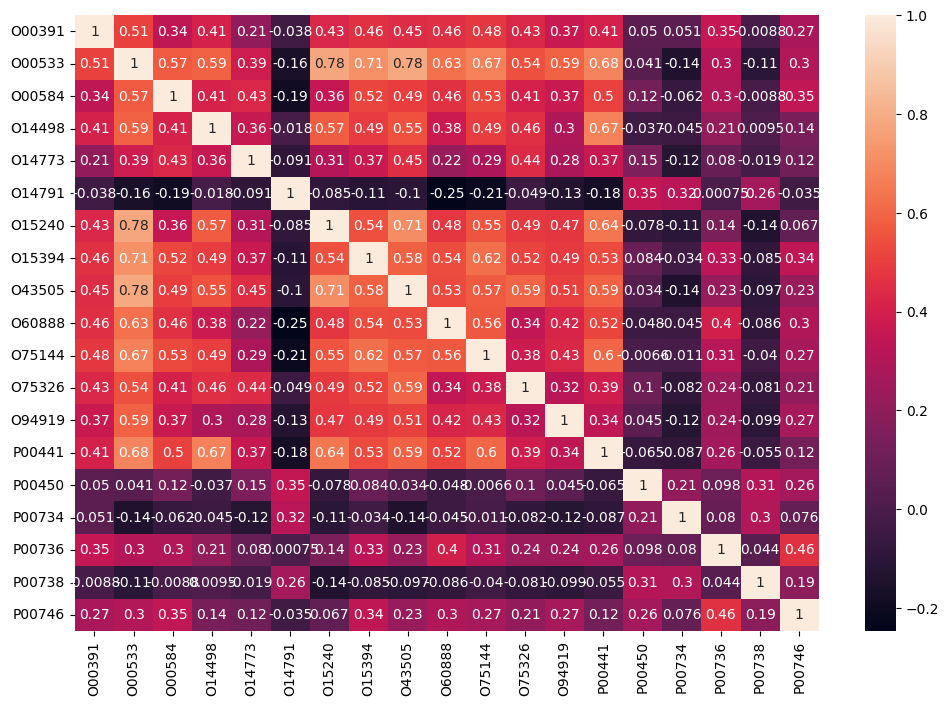

In [201]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);

In [202]:
# Checking which column has the highest correlation with which column
df=dataset_df.iloc[:,1:]
normalized_df = (df - df.min()) / (df.max() - df.min())
df=normalized_df
correlations = df.corr()  # Compute the correlation matrix
target_columns=['updrs_1','updrs_2','updrs_3','updrs_4']
# Iterate over each column in the DataFrame
# for column in target_columns:
#     # Find the column with the highest correlation (excluding self-correlation)
#     max_corr_col = correlations[column].drop(column).idxmax()

#     # Get the value of the highest correlation
#     max_corr_value = correlations[column][max_corr_col]

#     # Print the results
#     print(f"The column '{column}' has the highest correlation with '{max_corr_col}' (correlation value: {max_corr_value})")

# Iterate over each target column in the DataFrame
for column in target_columns:
    # Find the columns not in target_columns
    non_target_cols = [col for col in df.columns if col not in target_columns]

    # Find the column with the highest correlation (excluding self-correlation)
    max_corr_col = correlations.loc[non_target_cols, column].idxmax()

    # Get the value of the highest correlation
    max_corr_value = correlations.loc[non_target_cols, column].max()

    # Print the results
    print(f"The column '{column}' has the highest correlation with '{max_corr_col}' (correlation value: {max_corr_value})")

The column 'updrs_1' has the highest correlation with 'visit_month' (correlation value: 0.11344731137532477)
The column 'updrs_2' has the highest correlation with 'P01861' (correlation value: 0.1366246986240787)
The column 'updrs_3' has the highest correlation with 'HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR' (correlation value: 0.1512315629852863)
The column 'updrs_4' has the highest correlation with 'P16152' (correlation value: 0.11645953834563692)


In [203]:
dataset_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,104260.0,530223.0,NaN,7207.30,10053.0,0.0,3.0,0.0,13.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.9,25332.80,10053.0,12.0,4.0,2.0,8.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.1,21235.70,10053.0,18.0,2.0,2.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,129964.0,552232.0,65657.8,9876.98,10138.0,12.0,3.0,6.0,31.0,0.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,111799.0,NaN,56977.6,4903.09,10138.0,24.0,4.0,7.0,19.0,10.0


In [204]:
# Checking which column has the highest correlation with which column
df=dataset_df.iloc[:,1:20]
correlations = df.corr()  # Compute the correlation matrix

# Iterate over each column in the DataFrame
for column in df.columns:
    # Find the column with the highest correlation (excluding self-correlation)
    max_corr_col = correlations[column].drop(column).idxmax()

    # Get the value of the highest correlation
    max_corr_value = correlations[column][max_corr_col]

    # Print the results
    #print(f"The column '{column}' has the highest correlation with '{max_corr_col}' (correlation value: {max_corr_value})")

In [205]:
correlations = dataset_df.corr(numeric_only=True)  # Compute the correlation matrix

def replace_missing_values(df, row):
    for column in df.columns:
        if pd.isnull(row[column]):  # Check if the value is NaN
            # Sort columns by correlation in descending order
            sorted_columns = correlations[column].drop(column).sort_values(ascending=False).index

            # Find the first column with a non-NaN value
            for col in sorted_columns:
                if not pd.isnull(row[col]):
                    X = row[col]  # Known value (X)
                    correlation = correlations[column][col]  # Correlation coefficient
                    mean_X = df[col].mean()  # Mean of the most correlated column
                    mean_Y = df[column].mean()
                    std_X = df[col].std()
                    std_Y = df[column].std()
                    Y = mean_Y + correlation * (std_Y / std_X) * (X - mean_X)
                    df.loc[row.name, column] = Y
                    break  # Stop after finding the first non-NaN value
    return row

# Updating each missing value per raw of the dataframe
for row_index in range(len(dataset_df)):
  row = dataset_df.loc[row_index]
  #updated_row = replace_missing_values(dataset_df,row)

  # Update the original DataFrame with the updated row
  replace_missing_values(dataset_df,row)#updated_row dataset_df.loc[row_index] =

In [206]:
dataset_df.columns

Index(['visit_id', 'O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791',
       'O15240', 'O15394', 'O43505',
       ...
       'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK', 'YYWGGQYTWDMAK',
       'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3',
       'updrs_4'],
      dtype='object', length=1202)

In [207]:
# Calculate the total number of values in the dataframe
total_values = dataset_df.size

# Calculate the number of NaN values in the dataframe
nan_values = dataset_df.isna().sum().sum()

# Calculate the percentage of NaN values
percentage_nan = (nan_values / total_values) * 100

print(f"The percentage of NaN values in the dataframe is: {percentage_nan:.2f}%")


The percentage of NaN values in the dataframe is: 0.00%


### how much the imputation affected the correlation?

<ipython-input-208-8a7a0431d523>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);


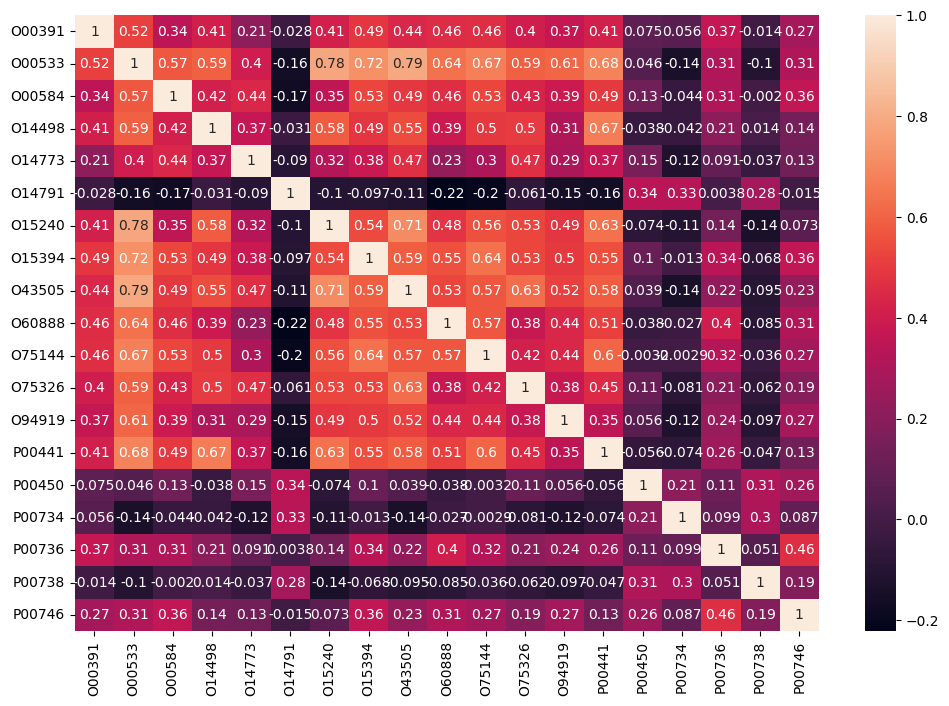

In [208]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset_df.iloc[:,:20].corr(), annot=True);

In [82]:
# Checking which column has the highest correlation with which column
df=dataset_df.iloc[:,1:]
normalized_df = (df - df.min()) / (df.max() - df.min())
df=normalized_df
correlations = df.corr()  # Compute the correlation matrix
target_columns=['updrs_1','updrs_2','updrs_3','updrs_4']

# Iterate over each target column in the DataFrame
for column in target_columns:
    # Find the columns not in target_columns
    non_target_cols = [col for col in df.columns if col not in target_columns]

    # Find the column with the highest correlation (excluding self-correlation)
    max_corr_col = correlations.loc[non_target_cols, column].idxmax()

    # Get the value of the highest correlation
    max_corr_value = correlations.loc[non_target_cols, column].max()

    # Print the results
    print(f"The column '{column}' has the highest correlation with '{max_corr_col}' (correlation value: {max_corr_value})")

The column 'updrs_1' has the highest correlation with 'visit_month' (correlation value: 0.11350099326994106)
The column 'updrs_2' has the highest correlation with 'P01861' (correlation value: 0.10951291397916807)
The column 'updrs_3' has the highest correlation with 'YVMLPVADQDQC(UniMod_4)IR' (correlation value: 0.1254905837295863)
The column 'updrs_4' has the highest correlation with 'visit_month' (correlation value: 0.08756819353843878)


# Prepare the timedelta for time series

The idea is now after the imputation to only keep the visit months that are multples of 6 months. so the predictions that we will have it will correspond to the next 6 months.

Keep only the feature we care aboout, since the protein values seem to have no correlation with the updrs scores, we exclude them at the moment until we see what we can do with them.

In [247]:
df= dataset_df[['patient_id', 'visit_month', 'updrs_1','updrs_2','updrs_3','updrs_4']]
df

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053.0,0.0,3.0,0.0,13.0,0.000000
1,10053.0,12.0,4.0,2.0,8.0,0.000000
2,10053.0,18.0,2.0,2.0,0.0,0.000000
3,10138.0,12.0,3.0,6.0,31.0,0.000000
4,10138.0,24.0,4.0,7.0,19.0,10.000000
...,...,...,...,...,...,...
1108,8699.0,24.0,11.0,10.0,13.0,2.000000
1109,942.0,12.0,5.0,2.0,25.0,0.000000
1110,942.0,24.0,2.0,3.0,23.0,0.749056
1111,942.0,48.0,2.0,6.0,35.0,0.000000


In [248]:
df.loc[:, 'visit_month'] = df['visit_month'].astype(int)
df.loc[:, 'patient_id'] = df['patient_id'].astype(int)

<ipython-input-248-55f60fd54c3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'visit_month'] = df['visit_month'].astype(int)
<ipython-input-248-55f60fd54c3a>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'visit_month'] = df['visit_month'].astype(int)
<ipython-input-248-55f60fd54c3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [232]:
# Assuming train_clinical_df is your DataFrame containing patient_id and visit_month columns
target_month_ids = [0, 6, 12, 18, 24, 36, 48, 60, 72, 84]
# Grouping data by patient_id and getting the unique visit_months for each patient
grouped_data = df.groupby('patient_id')['visit_month'].unique()

# Checking which patients have all the target_month_ids
patients_with_all_target_months = grouped_data[grouped_data.apply(lambda x: set(target_month_ids).issubset(x))]

# Getting the count of patients who have all the target_month_ids
total_patients_with_all_month_ids = len(patients_with_all_target_months)

# Alternatively, if you want to get a list of patient_ids who have all the target_month_ids, you can use:
# patient_ids_with_all_target_months = patients_with_all_target_months.index.tolist()

print("Total patients with all target month IDs:", total_patients_with_all_month_ids)
print("Total patients:", len(df.patient_id.unique()))
print("Percentage:", round(total_patients_with_all_month_ids*100/len(df.patient_id.unique()),0),"%")

Total patients with all target month IDs: 0
Total patients: 293
Percentage: 0.0 %


In [233]:
df

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053,0,3.0,0.0,13.0,0.000000
1,10053,12,4.0,2.0,8.0,0.000000
2,10053,18,2.0,2.0,0.0,0.000000
3,10138,12,3.0,6.0,31.0,0.000000
4,10138,24,4.0,7.0,19.0,10.000000
...,...,...,...,...,...,...
1108,8699,24,11.0,10.0,13.0,2.000000
1109,942,12,5.0,2.0,25.0,0.000000
1110,942,24,2.0,3.0,23.0,0.749056
1111,942,48,2.0,6.0,35.0,0.000000


In [234]:
# we want to select only the data that are every 6 months
target_month_ids = [0, 6, 12, 18, 24, 36, 48, 60, 72, 84]

def create_time_frame(df):
  return df[ df['visit_month'].isin(time_delta) ]


In [235]:
df=create_time_frame(df)
df


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,10053,0,3.0,0.0,13.0,0.000000
1,10053,12,4.0,2.0,8.0,0.000000
2,10053,18,2.0,2.0,0.0,0.000000
3,10138,12,3.0,6.0,31.0,0.000000
4,10138,24,4.0,7.0,19.0,10.000000
...,...,...,...,...,...,...
1108,8699,24,11.0,10.0,13.0,2.000000
1109,942,12,5.0,2.0,25.0,0.000000
1110,942,24,2.0,3.0,23.0,0.749056
1111,942,48,2.0,6.0,35.0,0.000000


In [249]:
df= df.sort_values(['patient_id', 'visit_month'])
df

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
849,55,0,10.0,6.0,15.000000,2.402940
852,55,6,8.0,10.0,34.000000,1.987531
850,55,12,10.0,10.0,41.000000,0.000000
851,55,36,17.0,18.0,51.000000,0.000000
1112,942,6,8.0,2.0,21.000000,1.941825
...,...,...,...,...,...,...
1065,64674,84,11.0,15.0,45.000000,4.000000
1066,65043,0,2.0,6.0,16.000000,0.750305
1067,65043,12,4.0,7.0,14.000000,0.000000
1068,65043,24,4.0,8.0,21.490746,0.000000


In [258]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.preprocessing import StandardScaler

def prepare_time_series_data(df, sequence_length=3):
    # Standardize the 'target_value' columns
    scaler = StandardScaler()
    for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    # Group the DataFrame by 'patient_id'
    grouped = df.groupby('patient_id')

    sequences = []
    targets = []

    # Iterate over each group (patient_id) and create sequences
    for _, group_df in grouped:
        n = len(group_df)
        if n >= sequence_length:
            # Create sequences and targets for this patient_id
            for i in range(n - sequence_length):
                sequences.append(group_df.iloc[i:i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)
                targets.append(group_df.iloc[i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)

    # Convert sequences and targets to numpy arrays and reshape to 3D arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    sequences = sequences.reshape(-1, sequence_length, 4)
    targets = targets.reshape(-1, 4)

    return sequences, targets, scaler


# Assuming 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', and 'updrs_4' columns exist in your DataFrame
# and the DataFrame is sorted by 'patient_id' and 'visit_month'

# Step 1: Prepare time series data
sequence_length = 3  # You can adjust this as needed
sequences, targets, scaler = prepare_time_series_data(df, sequence_length=sequence_length)

# Step 2: Train-test split
# Here we will perform a chronological train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)

# Step 3: Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 4)),  # Input shape (sequence_length, 4)
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam', loss='mse')

# Step 4: Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Step 5: Evaluate the model
loss = model.evaluate(X_test, y_test)

# Step 6: Make predictions
patients = [55, 942, 1517]
predictions = dict(zip(patients, [None]*len(patients)))
for patient in patients:
    # Assuming 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', and 'visit_month' columns exist in your DataFrame
    # Prepare variable-length sequence for prediction
    patient_data = dataset_df[dataset_df.patient_id == patient]

    # Collect all four target values in the sequence
    sequence = patient_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values

    # Pad or truncate the sequence to the desired maximum length
    if len(sequence) < sequence_length:
        sequence = np.pad(sequence, ((0, sequence_length - len(sequence)), (0, 0)), 'constant')
    else:
        sequence = sequence[-sequence_length:]

    X_new = sequence.reshape(1, sequence_length, 4)  # Reshape for LSTM input (sequence_length, 4)
    predicted_scaled = model.predict(X_new)
    predicted_target = scaler.inverse_transform(predicted_scaled)
    predictions[str(patient)]=predicted_target
    print('Patient id = ', patient)
    print("Predicted target values:", predicted_target)



Epoch 1/50
8/8 [==============================] - 8s 136ms/step - loss: 1.4150 - val_loss: 0.7486
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 1.2061 - val_loss: 0.6671
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 1.0216 - val_loss: 0.6016
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.8614 - val_loss: 0.5523
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.7338 - val_loss: 0.5180
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6557 - val_loss: 0.5011
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.6109 - val_loss: 0.4880
Epoch 8/50
8/8 [==============================] - 0s 27ms/step - loss: 0.5885 - val_loss: 0.4696
Epoch 9/50
8/8 [==============================] - 0s 21ms/step - loss: 0.5685 - val_loss: 0.4479
Epoch 10/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5488 - val_loss: 0.4308
Epoch 11/50
8/8 [===========

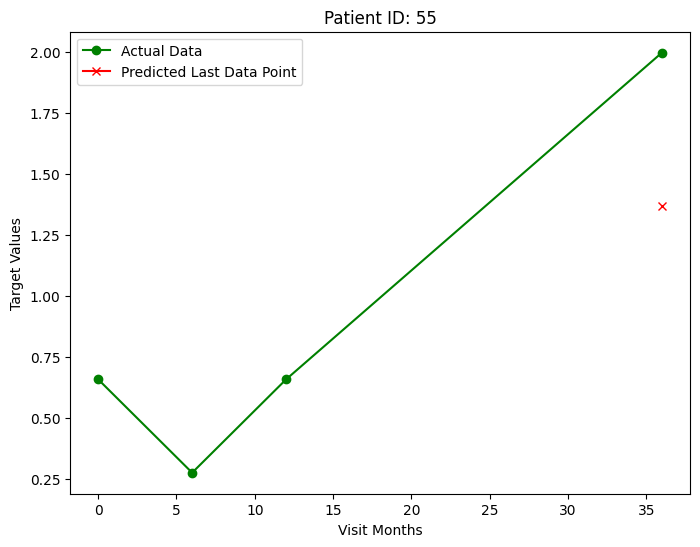

In [300]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and have 'X_test', 'y_test', and 'scaler' defined.

# Step 1: Filter test set for a specific patient_id
specific_patient_id = 55  # Replace with the patient_id you want to analyze

# Step 3: Inverse transform the actual target values to their original scale
#actual_target = scaler.inverse_transform(df[df['patient_id']==specific_patient_id]['updrs_1'].values)  # Get the actual values for the first (and only) sequence
actual_target=list(df[df['patient_id']==specific_patient_id]['updrs_1'].values)
predicted_target =predictions[str(specific_patient_id)][0][0]
visit_months=list(df[df.patient_id==specific_patient_id]['visit_month'].values)
time_steps = list(range(len(actual_target) - 1))  # Exclude the last data point for comparison

plt.plot(visit_months, actual_target, label='Actual Data', marker='o', color='green')
plt.plot(visit_months[-1], predicted_target, label='Predicted Last Data Point', marker='x', color='red')

plt.xlabel('Visit Months')
plt.ylabel('Target Values')
plt.title(f'Patient ID: {specific_patient_id}')
plt.legend()
plt.show()



# Multistep prediction

In [238]:

# Assuming 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', and 'updrs_4' columns exist in your DataFrame
# and the DataFrame is sorted by 'patient_id' and 'visit_month'
def prepare_time_series_data(df, sequence_length=3):
    # Standardize the 'target_value' columns
    scaler = StandardScaler()
    for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    # Group the DataFrame by 'patient_id'
    grouped = df.groupby('patient_id')

    sequences = []
    targets = []

    # Iterate over each group (patient_id) and create sequences
    for _, group_df in grouped:
        n = len(group_df)
        if n >= sequence_length:
            # Create sequences and targets for this patient_id
            for i in range(n - sequence_length):
                sequences.append(group_df.iloc[i:i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)
                targets.append(group_df.iloc[i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)

    # Convert sequences and targets to numpy arrays and reshape to 3D arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    sequences = sequences.reshape(-1, sequence_length, 4)
    targets = targets.reshape(-1, 4)

    return sequences, targets, scaler
# Step 1: Prepare time series data
sequence_length = 3  # You can adjust this as needed
sequences, targets, scaler = prepare_time_series_data(df, sequence_length=sequence_length)

# Step 2: Train-test split
# Here we will perform a chronological train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)

# Step 3: Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 4)),  # Input shape (sequence_length, 4)
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam', loss='mse')

# Step 4: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Step 5: Evaluate the model
loss = model.evaluate(X_test, y_test)
# Step 7: Make multi-step predictions
patients = [55, 942, 1517]
num_steps = 3  # Number of future steps to predict

for patient in patients:
    # Assuming 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', and 'visit_month' columns exist in your DataFrame
    # Prepare variable-length sequence for prediction
    patient_data = dataset_df[dataset_df.patient_id == patient]

    # Collect all four target values in the sequence
    sequence = patient_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values

    # Pad or truncate the sequence to the desired maximum length
    if len(sequence) < sequence_length:
        sequence = np.pad(sequence, ((0, sequence_length - len(sequence)), (0, 0)), 'constant')
    else:
        sequence = sequence[-sequence_length:]

    X_new = sequence.reshape(1, sequence_length, 4)  # Reshape for LSTM input (sequence_length, 4)
    predicted_values = []  # Store the predicted values for all steps

    for step in range(num_steps):
        # Predict one step into the future
        predicted_scaled = model.predict(X_new)
        predicted_values.append(scaler.inverse_transform(predicted_scaled)[0])

        # Update the input sequence with the predicted value
        new_value = predicted_scaled.reshape(1, 1, 4)
        X_new = np.concatenate([X_new[:, 1:, :], new_value], axis=1)

    predicted_values = np.array(predicted_values)
    print('Patient id =', patient)
    print("Predicted target values for the next", num_steps, "steps:")
    print(predicted_values)


Epoch 1/10
8/8 [==============================] - 5s 135ms/step - loss: 1.2381 - val_loss: 0.6642
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 1.0904 - val_loss: 0.6046
Epoch 3/10
8/8 [==============================] - 0s 13ms/step - loss: 0.9563 - val_loss: 0.5510
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 0.8199 - val_loss: 0.5058
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 0.6984 - val_loss: 0.4734
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 0.6162 - val_loss: 0.4550
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 0.5817 - val_loss: 0.4460
Epoch 8/10
8/8 [==============================] - 0s 16ms/step - loss: 0.5578 - val_loss: 0.4302
Epoch 9/10
8/8 [==============================] - 0s 14ms/step - loss: 0.5344 - val_loss: 0.4084
Epoch 10/10
1/1 [==============================] - 0s 39ms/step
Patient id = 55
Predicted target values for the next 3 steps:


In [62]:
##New approach
# To take into account the information of visit_month for predictions and handle the potential confusion between different patients' visits with different time intervals, you can modify the input sequences to the LSTM model. Instead of using fixed-length sequences, you can create variable-length sequences for each patient by padding or truncating the data appropriately. Padding involves adding zeros or a special token to make all sequences of the same length, while truncating involves cutting off the sequences to a fixed length.

# Here's how you can modify the code to handle variable-length sequences:

# Define a maximum sequence length that you want to consider for each patient. For example, if you choose 36 months as the maximum, all sequences will be padded or truncated to that length.

# When preparing the time series data, create a dictionary where the keys are patient IDs, and the values are their respective variable-length sequences. Then, pad or truncate each sequence to the desired maximum length.

# Modify the input shape of the LSTM layer in the model to accept variable-length sequences. For this, you need to use None as the sequence length in the input shape. The modified input shape will be (None, 1) since you have a single feature (1) for each time step.

# During training and prediction, pass the variable-length sequences to the LSTM model.

In [239]:
# lets see how our data look for one of the patients
dataset_df_55=dataset_df[dataset_df.patient_id ==55]
dataset_df_55

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
849,55_0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,...,165851.0,437305.0,46289.2,14898.4,55.0,0.0,10.0,6.0,15.0,2.402940
850,55_12,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,...,181763.0,452253.0,54725.1,21841.1,55.0,12.0,10.0,10.0,41.0,0.000000
851,55_36,13530.8,753832.0,43048.9,43503.6,33577.6,5367.06,101056.0,67588.6,317490.0,...,203680.0,498621.0,52792.7,13973.7,55.0,36.0,17.0,18.0,51.0,0.000000
852,55_6,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,...,144607.0,457891.0,40047.7,20703.9,55.0,6.0,8.0,10.0,34.0,1.987531


In [240]:
# add a field of time_passes
dataset_df_55["horizon"] = dataset_df_55["visit_month"].diff()
dataset_df_55["horizon"].fillna(0, inplace=True)
dataset_df_55

<ipython-input-240-8ccc3e11ef77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df_55["horizon"] = dataset_df_55["visit_month"].diff()
<ipython-input-240-8ccc3e11ef77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df_55["horizon"].fillna(0, inplace=True)


,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,horizon
849,55_0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,...,437305.0,46289.2,14898.4,55.0,0.0,10.0,6.0,15.0,2.402940,0.0
850,55_12,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,...,452253.0,54725.1,21841.1,55.0,12.0,10.0,10.0,41.0,0.000000,12.0
851,55_36,13530.8,753832.0,43048.9,43503.6,33577.6,5367.06,101056.0,67588.6,317490.0,...,498621.0,52792.7,13973.7,55.0,36.0,17.0,18.0,51.0,0.000000,24.0
852,55_6,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,...,457891.0,40047.7,20703.9,55.0,6.0,8.0,10.0,34.0,1.987531,-30.0


In [241]:
# lets apply this to all dataframe:

# Calculate the difference (delta) for each patient_id separately
df['delta_month'] = df.groupby('patient_id')['visit_month'].diff()
df['delta_month'].fillna(0, inplace=True)
df['delta_month']=df['delta_month'].astype(int)
df['visit_times']=df.groupby('patient_id')['patient_id'].transform('count')
df

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,delta_month,visit_times
849,55,0,0.646793,0.029427,-0.153340,0.320172,0,4
852,55,6,0.269881,0.706865,1.122462,0.142958,6,4
850,55,12,0.646793,0.706865,1.592494,-0.704925,6,4
851,55,36,1.965987,2.061740,2.263969,-0.704925,24,4
1112,942,6,0.269881,-0.648010,0.249545,0.123460,0,4
...,...,...,...,...,...,...,...,...
1065,64674,84,0.835250,1.553662,1.861084,1.001479,36,6
1066,65043,0,-0.860856,0.029427,-0.086193,-0.384844,0,4
1067,65043,12,-0.483944,0.198787,-0.220488,-0.704925,12,4
1068,65043,24,-0.483944,0.368146,0.282497,-0.704925,12,4


In [242]:

# Assuming 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', and 'updrs_4' columns exist in your DataFrame
# and the DataFrame is sorted by 'patient_id' and 'visit_month'
def prepare_time_series_data(df, sequence_length=3):
    # Standardize the 'target_value' columns
    scaler = StandardScaler()
    for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    # Group the DataFrame by 'patient_id'
    grouped = df.groupby('patient_id')

    sequences = []
    targets = []

    # Iterate over each group (patient_id) and create sequences
    for _, group_df in grouped:
        n = len(group_df)
        if n >= sequence_length:
            # Create sequences and targets for this patient_id
            for i in range(n - sequence_length):
                sequences.append(group_df.iloc[i:i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)
                targets.append(group_df.iloc[i + sequence_length][['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values)

    # Convert sequences and targets to numpy arrays and reshape to 3D arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    sequences = sequences.reshape(-1, sequence_length, 4)
    targets = targets.reshape(-1, 4)

    return sequences, targets, scaler
# Step 1: Prepare time series data
sequence_length = 3  # You can adjust this as needed
sequences, targets, scaler = prepare_time_series_data(df, sequence_length=sequence_length)

# Step 2: Train-test split
# Here we will perform a chronological train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)

# Step 3: Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 4)),  # Input shape (sequence_length, 4)
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam', loss='mse')

# Step 4: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Step 5: Evaluate the model
loss = model.evaluate(X_test, y_test)
# Step 7: Make multi-step predictions
patients = [55, 942, 1517]
num_steps = 4  # Number of future steps to predict

for patient in patients:
    # Assuming 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', and 'visit_month' columns exist in your DataFrame
    # Prepare variable-length sequence for prediction
    patient_data = dataset_df[dataset_df.patient_id == patient]

    # Collect all four target values in the sequence
    sequence = patient_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values

    # Pad or truncate the sequence to the desired maximum length
    if len(sequence) < sequence_length:
        sequence = np.pad(sequence, ((0, sequence_length - len(sequence)), (0, 0)), 'constant')
    else:
        sequence = sequence[-sequence_length:]

    X_new = sequence.reshape(1, sequence_length, 4)  # Reshape for LSTM input (sequence_length, 4)
    predicted_values = []  # Store the predicted values for all steps

    for step in range(num_steps):
        # Predict one step into the future
        predicted_scaled = model.predict(X_new)
        predicted_values.append(scaler.inverse_transform(predicted_scaled)[0])

        # Update the input sequence with the predicted value
        new_value = predicted_scaled.reshape(1, 1, 4)
        X_new = np.concatenate([X_new[:, 1:, :], new_value], axis=1)

    predicted_values = np.array(predicted_values)
    print('Patient id =', patient)
    print("Predicted target values for the next", num_steps, "steps:")
    print(predicted_values)


Epoch 1/10
8/8 [==============================] - 5s 136ms/step - loss: 1.1943 - val_loss: 0.6288
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 1.0456 - val_loss: 0.5695
Epoch 3/10
8/8 [==============================] - 0s 23ms/step - loss: 0.9074 - val_loss: 0.5203
Epoch 4/10
8/8 [==============================] - 0s 30ms/step - loss: 0.7867 - val_loss: 0.4838
Epoch 5/10
8/8 [==============================] - 0s 19ms/step - loss: 0.6738 - val_loss: 0.4600
Epoch 6/10
8/8 [==============================] - 0s 20ms/step - loss: 0.6097 - val_loss: 0.4518
Epoch 7/10
8/8 [==============================] - 0s 24ms/step - loss: 0.5763 - val_loss: 0.4444
Epoch 8/10
8/8 [==============================] - 0s 19ms/step - loss: 0.5569 - val_loss: 0.4297
Epoch 9/10
8/8 [==============================] - 0s 17ms/step - loss: 0.5344 - val_loss: 0.4091
Epoch 10/10
1/1 [==============================] - 0s 46ms/step
Patient id = 55
Predicted target values for the next 4 steps:
